In [8]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)

In [9]:
 X, y = mnist["data"], mnist["target"]

In [10]:
X.shape

(70000, 784)

In [11]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
y.shape

(70000,)

In [13]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

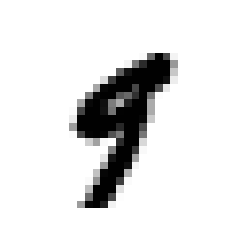

In [14]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [15]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [16]:
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [17]:
# TRAINING A BINARY CLASSIFIER
y_train_5 = (y_train == '5') # True for all 5s, False for all other digits.
y_test_5 = (y_test == '5')
y_train_5

array([False, False, False, ..., False, False, False])

In [18]:
# Okay, now let’s pick a classifier and train it. A good place to start is with a Stochastic Gradient Descent (SGD) classifier, using Scikit-Learn’s SGDClassifier class. This classifier has the advantage of being capable of handling very large datasets efficiently
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [19]:
sgd_clf.predict([some_digit])

array([False])

In [20]:
# PERFORMANCE MEASURES
# --- Measuring Accuracy Using Cross-Validation ---
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96935, 0.9626 , 0.9569 ])

In [21]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [22]:
y_train_pred

array([False, False, False, ..., False, False, False])

In [23]:
# --- Confusing Matrix ---
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53739,   840],
       [ 1383,  4038]], dtype=int64)

In [24]:
# --- Precision and Recall ---
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 4344 / (4344 + 1307)

0.8277982779827798

In [25]:
recall_score(y_train_5, y_train_pred) # == 4344 / (4344 + 1077)

0.7448810182623132

In [26]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.784153801339936

In [27]:
# --- Precision/Recall Tradeoff ---
# For each instance, it computes a score based on a decision function, and if that score is greater than a threshold, it assigns the instance to the positive
# class, or else it assigns it to the negative class. Scikit-Learn does not let you set the threshold directly, but it does give you access to
# the decision scores that it uses to make predictions. 
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-8177.73061078])

In [28]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [29]:
# The SGDClassifier uses a threshold equal to 0, so the previous code returns the same
# result as the predict() method (i.e., True). Let’s raise the threshold:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [30]:
# So how can you decide which threshold to use? For this you will first need to get the
# scores of all instances in the training set using the cross_val_predict() function
# again, but this time specifying that you want it to return decision scores instead of
# predictions:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [31]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

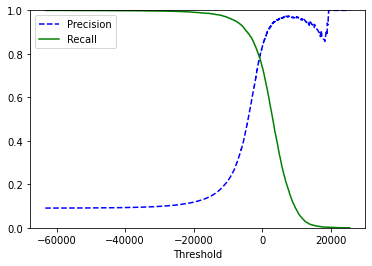

In [32]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [33]:
# Now you can simply select the threshold value that gives you the best precision/recall tradeoff for your task. 

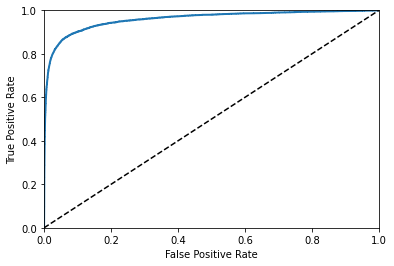

In [34]:
# --- ROC curve ---
# The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plot‐
# ting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate.

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

In [35]:
# Once again there is a tradeoff: the higher the recall (TPR), the more false positives
# (FPR) the classifier produces. The dotted line represents the ROC curve of a purely
# random classifier; a good classifier stays as far away from that line as possible (toward
# the top-left corner).

# One way to compare classifiers is to measure the area under the curve (AUC). A per‐
# fect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will
# have a ROC AUC equal to 0.5.

In [36]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9593002612315521

In [37]:
# Let’s train a RandomForestClassifier and compare its ROC curve and ROC AUC score to the SGDClassifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [38]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

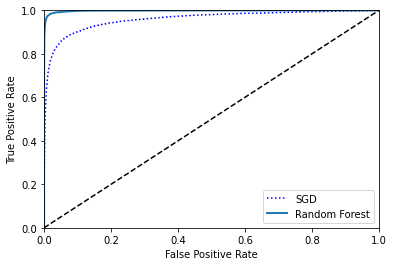

In [39]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [40]:
roc_auc_score(y_train_5, y_scores_forest)

0.9982883199463457

In [41]:
# MULTICLASS CLASSIFICATION
# Whereas binary classifiers distinguish between two classes, multiclass classifiers (also called multinomial classifiers) can distinguish between more than two classes.

In [42]:
sgd_clf.fit(X_train, y_train) # y_train, not y_train_5
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [43]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-24745.98188171, -31319.40482699, -18584.99143254,
         -1011.8447556 ,  -1944.1303969 ,  -7539.65374123,
        -33629.25274955,  -4035.79653468,  -2133.78122726,
         -3954.34337491]])

In [44]:
np.argmax(some_digit_scores)

3

In [45]:
sgd_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1')

In [46]:
sgd_clf.classes_[3]

'3'

In [47]:
# If you want to force ScikitLearn to use one-versus-one or one-versus-all
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array(['9'], dtype=object)

In [48]:
len(ovo_clf.estimators_)

45

In [49]:
# Training a RandomForestClassifier is just as easy
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array(['9'], dtype=object)

In [50]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.01, 0.  , 0.  , 0.04, 0.  , 0.  , 0.01, 0.  , 0.94]])

In [51]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.879  , 0.8813 , 0.86545])

In [52]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [67]:
# ERROR ANALYSIS
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

TypeError: cross_val_predict() got an unexpected keyword argument 'dual'

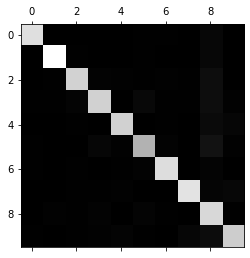

In [68]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [69]:
# The 5s look slightly darker than the other digits, which could mean that there are fewer images of 5s in the dataset or that
# the classifier does not perform as well on 5s as on other digits.

In [70]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
# Now you can clearly see the kinds of errors the classifier makes. Remember that rows
# represent actual classes, while columns represent predicted classes. The columns for
# classes 8 and 9 are quite bright, which tells you that many images get misclassified as
# 8s or 9s.

In [ ]:
# MULTILABEL CLASSIFICATION
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

In [ ]:
knn_clf.predict([some_digit])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average="macro")

In [ ]:
# MULTIOUTPUT CLASSIFICATION
noise = rnd.randint(0, 100, (len(X_train), 784))
noise = rnd.randint(0, 100, (len(X_test), 784))
X_train_mod = X_train + noise
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)